In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
script_dir = os.getcwd()

from sde.SDE_AM_lib import (
    SDEAMTrain,
    NNHyperparameters,
    theoretical_mean_loss_estimate
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

2025-01-12 01:45:44.224663: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 01:45:44.229261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-12 01:45:44.229275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
random_seed = 2
step_size = .25
n_pts = 20000

n_dimensions = 3

In [3]:
# EXAMPLE 2
def f_1(x):
    A = 0
    B = np.array([[-1], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = 0
    B = np.array([[0], [-1], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_3(x):
    A = 0
    B = np.array([[0], [0], [-1]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x), f_3(x)]))
    return drift


def sigma_11(x):
    A = 0.02045836
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = -0.03502162
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_13(x):
    A = -0.02678421
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = 0.06355898
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_23(x):
    A = 0.02981971
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_33(x):
    A = 0.12453806
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusivity(x):
    diffusivity = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x), sigma_13(x)], [sigma_12(x), sigma_22(x), sigma_23(x)], [sigma_13(x), sigma_23(x), sigma_33(x)]])))
    return diffusivity


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


print(true_diffusivity((0,0,0)))

rng = np.random.default_rng(random_seed)

xlim = [-.3, .3]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

[[0.02045836 0.03502162 0.02678421]
 [0.03502162 0.06355898 0.02981971]
 [0.02678421 0.02981971 0.12453806]]
data shape (20000, 3)


In [4]:
# network parameters
validation_split = .1
AM_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=10,
                                M_max=500,
                                lambda_reg=2e-6,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')



In [5]:
TMLE = theoretical_mean_loss_estimate()
mean_loss, SD, SD_val = TMLE.get_TMLE(true_diffusivity, n_dimensions, n_pts, validation_split, xlim, step_size)
print('Theoretical mean min loss:', mean_loss)
print('Loss standard deviation:', SD)
print('Validation loss standard deviation:', SD_val)

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "TMLE ex4 - 3d sde-spd.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_loss}\n")

Theoretical mean min loss: -6.552379230267681
Loss standard deviation: 0.009128709291752768
Validation loss standard deviation: 0.027386127875258306


In [10]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEAMTrain(n_dimensions=n_dimensions, diff_type="spd", constant_diff=False, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, plot=False)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

drift epoch: 10
diff epoch: 10
Observed loss: -6.488715673044949
Observed validation loss: -6.457993813285032
 Training time: 2.2880988121032715


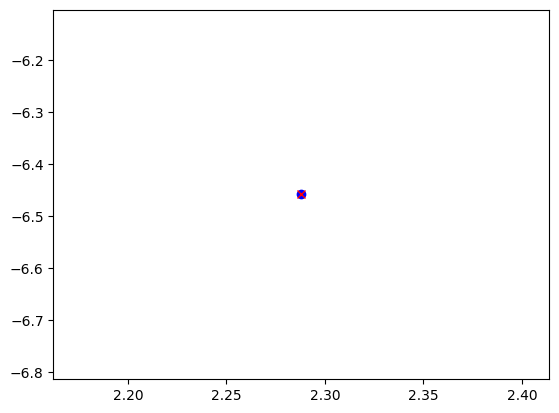

In [11]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "ex4 - 3d sde-spd wo resampling data.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


figures_per_row 3


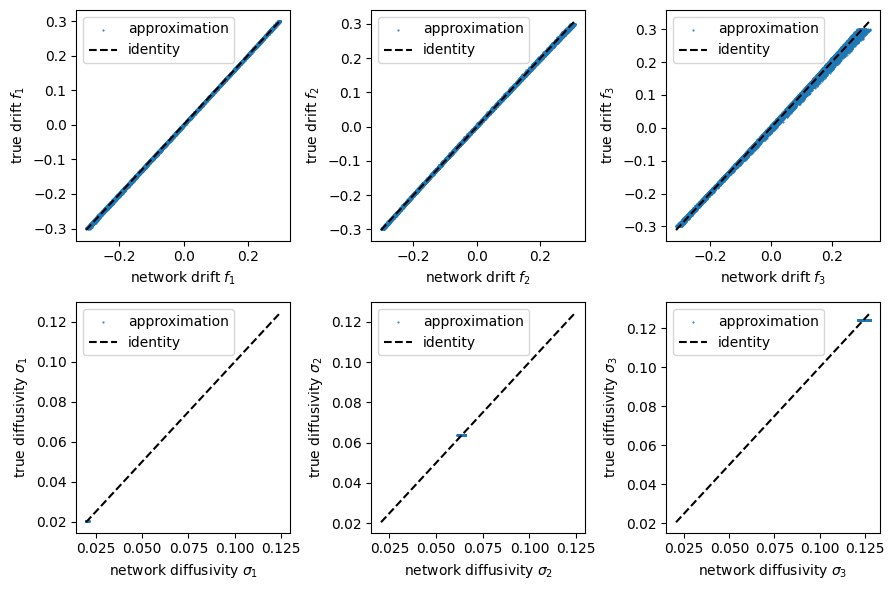

In [12]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(SAT.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, "ex4 - 3d sde-spd")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

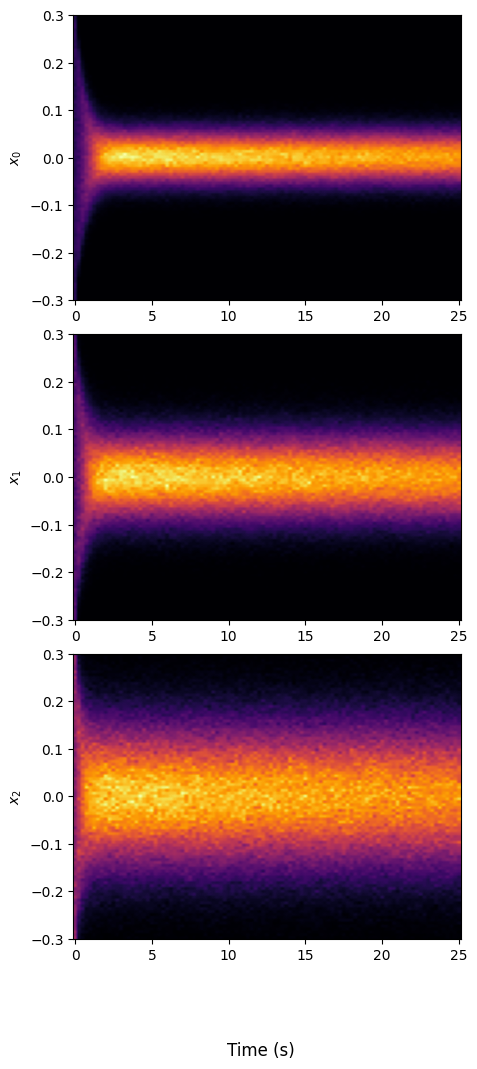

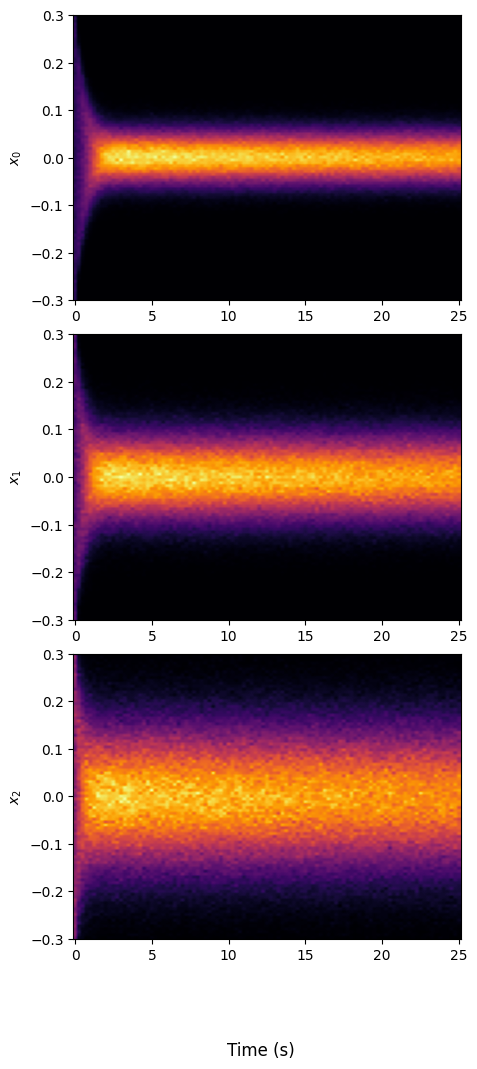

In [26]:
time = 100*step_size
true_paths = histogram_data(true_drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions)
ARFF_paths = histogram_data(SAT.drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions)

plot_histogram(true_paths, xlim[0], xlim[1], step_size)
plot_histogram(ARFF_paths, xlim[0], xlim[1], step_size)

output_dir = os.path.join(script_dir, 'histogram_data')

output_path_true = os.path.join(output_dir, "ex4 - 3d sde-spd data.txt")
with open(output_path_true, 'w') as file:
    file.write(f"{step_size},{xlim[0]},{xlim[1]}\n")

output_path_true = os.path.join(output_dir, "ex4 - 3d sde-spd true.npy")
np.save(output_path_true, true_paths)

output_path_ARFF = os.path.join(output_dir, "ex4 - 3d sde-spd ARFF.npy")
np.save(output_path_ARFF, ARFF_paths)

In [ ]:
T_steps = 100
N_iterates = 15

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(SAT.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylabel(r"$x_0$");
plot_results_1d(time_steps, paths_network, paths_true, plot_dim=1, linewidth=.5);
plt.gca().set_ylabel(r"$x_1$");

# plt.savefig(r"C:\Users\owen\Documents\jobs\KAUST\work\SDE AM project\project write up\saved plots\ex2 - 2d paths2.png")